## Titanic: Machine Learning from Disaster

In this example, we want to create a predictive model that will classify whether an individual survives the Titanic based on individual and trip characteristics. This is a toy example, but it serves as a pedagogical tool for showing many steps of modeling. Our final model should be able to take passenger information and predict whether that passenger would survive on the Titanic or not.


What type of ML problem is this?

In [1]:
# Imports
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import (
    ensemble,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

In [2]:
df = pd.read_excel("titanic.xls")
orig_df = df
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


#### Columns description

- pclass - Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
- survived - Survival (0 = No, 1 = Yes)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of siblings/spouses aboard
- parch - Number of parents/children aboard
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin
- embarked - Point of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
- boat - Lifeboat
- body - Body identification number

## Data Cleaning

Once we have the data, we need to ensure that it is in a format that we can use to create a model.

Most scikit-learn models require that the features be numeric (integer or float). Some models perform better if the data is standardized (given a mean value of 0 and a standard deviation of 1).

In [3]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

Use the .shape attribute of the DataFrame to inspect the number of rows and columns:

In [4]:
df.shape

(1309, 14)

Use the .describe method to get summary stats as well as see the count of nonnull data.

In [5]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### Outlier detection

Box plot

Below is an example of outlier detection in "fare" using box plot. 

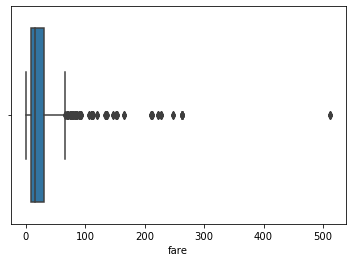

In [6]:
import seaborn as sns

sns.boxplot(x=df['fare'])

Example of a multi variate outliers detection using Scatter plot

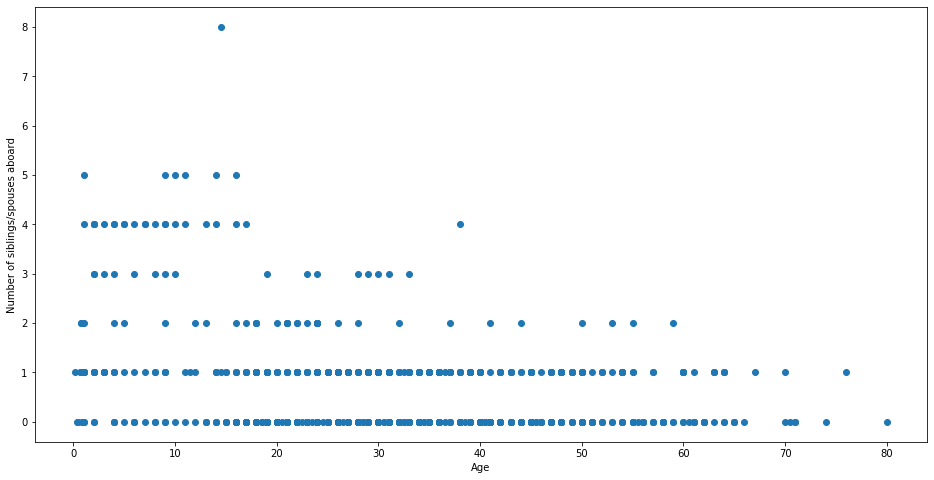

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['age'], df['sibsp'])
ax.set_xlabel('Age')
ax.set_ylabel('Number of siblings/spouses aboard')
plt.show()

Use the .isnull method to find columns or rows with missing values.

In [8]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Inspect rows with missing data

In [9]:
df.isnull().sum(axis=1).loc[:10]

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

Use the .value_counts method to examine the counts of the values

Pandas typically ignores null or NaN values. If we want to include those, use dropna=False to also show counts for NaN

In [10]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [11]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

Unless we are using NLP or extracting data out of text columns where every value is different, a model will not be able to take advantage of this column. The name column is an example of this.

In [12]:
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

We also want to drop columns that leak information. Both boat and body columns leak whether a passenger survived.

In [13]:
df = df.drop(
    columns=[
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ]
)

We need to create dummy columns from string columns. This will create new columns for sex and embarked.

In [14]:
df = pd.get_dummies(df)

In [15]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [16]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1


At this point the sex_male and sex_female columns are perfectly inverse correlated. We could either drop the column sex_male or rerun get_dummies with the option drop_first equal to true.

In [17]:
df = orig_df

In [18]:
df = df.drop(
    columns=[
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ]
)

In [19]:
df = pd.get_dummies(df, drop_first=True)

In [20]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [21]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1


Create a DataFrame (X) with the features and a series (y) with the labels.


In [22]:
X = df.drop(columns="survived")
y = df.survived

### Split train/test set

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [24]:
X.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q',
       'embarked_S'],
      dtype='object')

### Missing Data

There are various ways to handle missing data:
    
- Remove any row with missing data
- Remove any column with missing data
- Impute missing values
- Create an indicator column to signify data was missing


Percentage of missing values

In [25]:
df.isnull().mean() * 100

pclass         0.000000
survived       0.000000
age           20.091673
sibsp          0.000000
parch          0.000000
fare           0.076394
sex_male       0.000000
embarked_Q     0.000000
embarked_S     0.000000
dtype: float64

Example of imputing values with median

In [26]:
X_train.isnull().sum()

pclass          0
age           187
sibsp           0
parch           0
fare            1
sex_male        0
embarked_Q      0
embarked_S      0
dtype: int64

In [27]:
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

In [28]:
X_train.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

Example of imputing missing values using the **experimental** IterativeImputer class in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [30]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now we can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

num_cols = [
    "pclass",
    "age",
    "sibsp",
    "parch",
    "fare",
    "sex_male",
]

In [31]:
imputer = IterativeImputer()
imputed = imputer.fit_transform(
    X_train[num_cols])
X_train.loc[:, num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

In [32]:
X_train.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

### Data normalization & standardization



Normalizing or preprocessing data usually help many models perform better. 

Standardizing is translating the data so that it has a mean value of zero and a standard deviation of one.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [33]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
1214,3.0,26.984481,0.0,0.0,8.6625,1.0,0,1
677,3.0,26.000000,0.0,0.0,7.8958,1.0,0,1
534,2.0,19.000000,0.0,0.0,26.0000,0.0,0,1
1174,3.0,0.437798,8.0,2.0,69.5500,0.0,0,1
864,3.0,28.000000,0.0,0.0,7.7750,0.0,0,1


In [34]:
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
   'embarked_Q', 'embarked_S']
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
# converting the results (numpy array) back into pd dataframe for easier manipulation later on
X_train = pd.DataFrame(X_train, columns=cols)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [35]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0.825248,-0.128878,-0.498616,-0.432553,-0.473599,0.739795,-0.330089,0.660104
1,0.825248,-0.205639,-0.498616,-0.432553,-0.488120,0.739795,-0.330089,0.660104
2,-0.363317,-0.751431,-0.498616,-0.432553,-0.145224,-1.351725,-0.330089,0.660104
3,0.825248,-2.198733,6.897852,1.805972,0.679618,-1.351725,-0.330089,0.660104
4,0.825248,-0.049698,-0.498616,-0.432553,-0.490408,-1.351725,-0.330089,0.660104


### Code refactoring

In [36]:
def gen_dummies(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [37]:
def get_train_test(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    impute = IterativeImputer()
    train_fit = impute.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:train_fit[:,i] for i, c in enumerate(num_cols)})
    test_fit = impute.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        train_fit = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:train_fit[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

In [38]:
gen_dummies_df = gen_dummies(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test(
    gen_dummies_df, "survived", std_cols=std_cols
)

In [39]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
1214,0.825248,-0.167248,-0.498616,0.0,-0.473625,1,0,1
677,0.825248,-0.205255,-0.498616,0.0,-0.488146,1,0,1
534,-0.363317,-0.751526,-0.498616,0.0,-0.145246,0,0,1
1174,0.825248,-2.153148,6.897852,2.0,0.679608,0,0,1
864,0.825248,-0.049178,-0.498616,0.0,-0.490434,0,0,1
